# YamboCalculation: setting up the first G0W0 calculation

Once completed the [preliminary DFT step](../prerequisites/0_2_QE_starting_point.ipynb), we are ready to run a G0W0 calculation, for simplicity in the common Godby-Needs plasmon-pole approximation (PPA). In particular, we will compute the $\Gamma$-$\Gamma$ band gap of Silicon. 

The *p2y*+*yambo init*+*yambo* run is submitted by means of the *YamboCalculation* *Calcjob* class, implemented in the *aiida-yambo* plugin. This does not involve any post processing decisional step (e.g. error handling, automatic determination of quasiparticle band gaps and/or excitonic eigenvalues).

Input file generation and output parsing is done using the [*Yambopy*](https://github.com/yambo-code/yambopy/blob/master/README.md) package as python dependence.

As in the [*02_QE_starting_point*](../prerequisites/0_2_QE_starting_point.ipynb) module, we create a builder instance and then we submit it to the AiiDA scheduler.

In [1]:
from aiida import orm, load_profile
load_profile()

from aiida.plugins import CalculationFactory
from aiida.engine import submit

import yaml

### Loading the YamboCalculation class and the corresponding builder:

In [2]:
YamboCalculation = CalculationFactory('yambo.yambo')
builder = YamboCalculation.get_builder()

It is possible to inspect all the possible inputs that we can provide to the builder, using the tab completion feature:

```python
builder. # + tab completion
```

### Setting *yambo*, *p2y* codes and resources


In [3]:
with open("../configuration/codes_localhost.yaml", 'r') as stream:
    codes = yaml.safe_load(stream)
    
with open("../configuration/resources_localhost.yaml", 'r') as stream:
    resources = yaml.safe_load(stream)
    
builder.code = orm.load_code(codes["yambocode_id"])                    # yambo executable
builder.preprocessing_code = orm.load_code(codes["yamboprecode_id"])   # p2y   executable
builder.metadata.options = resources                                   # computational settings

## The yambo parameters

The input parameters used to run a yambo simulation (what usually is written in the *yambo.in* file for an ordinary yambo calculation), must be provided as an AiiDA Dict data type. This can be done first creating a python dictionary (e.g. `yambo_parameters`), and then converting it into the right AiiDA type:

In [4]:
yambo_parameters = {
    'arguments': [                                      # <=== runlevels
        'dipoles',
        'HF_and_locXC',
        'dipoles',
        'gw0',
        'ppa',],
    'variables': {                                      # <=== parameters
        'Chimod': 'hartree',
        'DysSolver': 'n',
        'GTermKind': 'BG',
        'NGsBlkXp': [2, 'Ry'],
        'BndsRnXp': [[1, 50], ''],
        'GbndRnge': [[1, 50], ''],
        'QPkrange': [[[1, 10, 8, 9]], ''],
        },
    }

builder.parameters = orm.Dict(dict=yambo_parameters)

Runlevels are included under the 'arguments' key, as a list of strings. Parameters are instead in the 'variables' dictionary, as you can see. The format of the `yambo_parameters` is the same as the one that you should use in a *yambopy* calculation (indeed, to write the input file, the code uses the `YamboIn()` class of *yambopy*).

**Advanced settings**: You can also provide a settings dictionary, where to specify some instructions (False is default for any of them)

In [5]:
settings = {
    'INITIALISE':    False,      # if True, run only p2y and yambo initialization
    'COPY_DBS':      False,      # if True, copy the out folder of a previous yambo calculation
    'COPY_SAVE':     False,      # if True, copy the SAVE folder of a previous yambo calculation
    'RESTART_YAMBO': False,      # if True, soft-link the out folder of a previous yambo calculation
}

builder.settings = orm.Dict(dict=settings)

Finally, to retrieve additional files, you can provide their names in the input settings Dict:

```python
settings_retrieve = {
	"ADDITIONAL_RETRIEVE_LIST":[
		'LOG/l-*',
		],
	}

settings.update(settings_retrieve)
builder.settings = orm.Dict(dict=settings)
```

This selects the additional files that will  be retrieved and parsed after a calculation. Default retrieved files include the report files ``r-*``, text outputs ``o-*``, logs, the quasiparticle
database for GW calculations ``aiida.out/ndb.QP``, and the Hartree-Fock and local exchange
db ``aiida.out/ndb.HF_and_locXC``. Quantities
that you may want collect to further analyse are for example the dipoles or the dielectric function databases, output of a typical GW
calculation. In the above example we just selected all the log files.

### Setting the QuantumEspresso parent nscf calculation

Yambo simulations require a DFT starting point, i.e. the ground state wavefunctions as obtained in a non self-consistent calculation. This was computed a the previous module ([*02_QE_starting_point*](../prerequisites/0_2_QE_starting_point.ipynb)).

In [6]:
nscf_pk = 397 # the pk of the previous nscf calculation or workchain.

builder.parent_folder = orm.load_node(nscf_pk).outputs.remote_folder

## RUN

In [7]:
run = None

In [8]:
if run:
    print('A calculation is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

uuid: 74c8b4af-ac28-498c-8f5c-cfaa9c927f30 (pk: 406) (aiida.calculations:yambo.yambo)


## Inspecting the outputs

suppose that your calculation completed successfully:

In [11]:
run.is_finished_ok

True

Then you can access the outputs via the output method of the run instance: 

```python
run.outputs. #+TAB
```

For example, we have the array_ndb ArrayData, which essentially contains the information on the run.output.QP_DB (which can also be accessed directly):

In [12]:
run.outputs.array_ndb.get_arraynames()

['E',
 'Z',
 'Eo',
 'Sc',
 'Sx',
 'Vxc',
 'Band',
 'Kpoint',
 'nbands',
 'nkpoints',
 'qp_table',
 'E_minus_Eo',
 'Kpoint_index']

The quasiparticle corrections and the renormalization factors can be accessed from the YamboCalculation using the output bands and array data:

```python
energies_DFT = run.outputs.array_ndb.get_array('E_0')
QP_corrections =  run.outputs.array_ndb.get_array('E_minus_Eo')
energies_QP = run.outputs.array_ndb.get_array('E')
Z_factors =  run.outputs.array_ndb.get_array('Z')
kpoint_band_array = run.outputs.array_ndb.get_array('qp_table')
```

In [13]:
energies_DFT = run.outputs.array_ndb.get_array('Eo')
QP_corrections =  run.outputs.array_ndb.get_array('E_minus_Eo')
energies_QP = run.outputs.array_ndb.get_array('E')
Z_factors =  run.outputs.array_ndb.get_array('Z')
kpoint_band_array = run.outputs.array_ndb.get_array('qp_table')

The `energies_DFT` and `energies_QP` are in Hartree units (as well as the other related quantities). We can use the [*ASE*](https://wiki.fysik.dtu.dk/ase/) module `units` to convert easily to eV and plot the results:

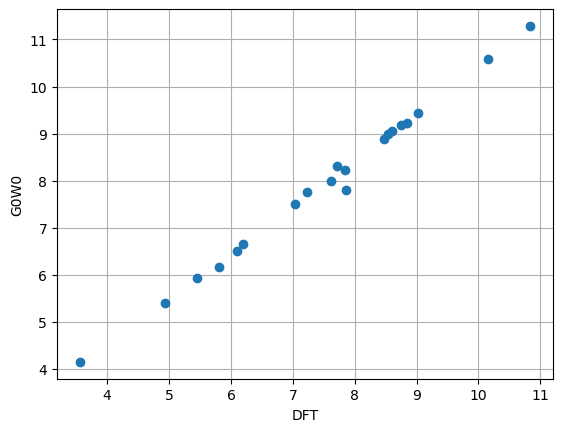

In [14]:
from ase import units
from matplotlib import pyplot as plt

plt.plot(energies_DFT.real*units.Ha,energies_QP.real*units.Ha,'o')
plt.ylabel('G0W0')
plt.xlabel('DFT')
plt.grid()

In [15]:
energies_QP

array([0.15260473-0.00062918j, 0.30543926-0.00073321j,
       0.2449609 -0.00079797j, 0.27555394-0.00073528j,
       0.2869233 -0.00081338j, 0.3466224 -0.00138697j,
       0.19870612-0.00066388j, 0.28550553+0.00048792j,
       0.21821916-0.00068966j, 0.38899362-0.00128087j,
       0.29379857-0.00086353j, 0.32658508-0.00109635j,
       0.22674923-0.00074854j, 0.23912312-0.00077418j,
       0.332801  -0.00125153j, 0.41478455-0.00132402j,
       0.3377324 -0.0012786j , 0.33880186-0.00091449j,
       0.3026804 -0.00085533j, 0.3306231 -0.00090288j], dtype=complex64)

The `output_parameters` Dict contains information on the simulation:

In [16]:
run.outputs.output_parameters.get_dict()

{'errors': [],
 'timing': [' <---> [01] MPI/OPENMP structure, Files & I/O Directories\n',
  ' <---> [02] CORE Variables Setup\n',
  ' <---> [03] Transferred momenta grid and indexing\n',
  ' <---> [04] Dipoles\n',
  ' <---> [05] Dynamic Dielectric Matrix (PPA)\n',
  ' <38s> [06] Local Exchange-Correlation + Non-Local Fock\n',
  ' <52s> [07] Dyson equation: Newton solver\n',
  ' <01m-18s> [08] Timing Overview\n',
  ' <01m-18s> [09] Game Over & Game summary\n'],
 'has_gpu': False,
 'memstats': [],
 'warnings': [],
 'Fermi(eV)': 6.467203,
 'game_over': True,
 'last_time': 78,
 'para_error': False,
 'time_error': False,
 'ns_db1_path': '/tmp/tmpfoi1pba2',
 'memory_error': False,
 'p2y_completed': True,
 'yambo_version': '5.x',
 'requested_time': 3600,
 'last_time_units': 'seconds',
 'yambo_wrote_dbs': True,
 'corrupted_fragment': False,
 'X_par_allocation_error': False}

As output, also the `ndb.QP` database is stored:

In [17]:
run.outputs.QP_db

<SinglefileData: uuid: 792f70ca-a586-413f-a4df-1a9feef581eb (pk: 409)>

This can be used again: for example, we may be interested on BSE simulations on top of these quasiparticle corrections. 
We can do the following (assuming the `builder.parameters` are now the one for a BSE calculation):

```python
    builder.QP_corrections = orm.load_node(2032)   # ---> QP_db node
    params['variables']['KfnQPdb'] =  "E < ./ndb.QP"
    builder.parameters = orm.Dict(dict=params)
```

### How to access the remote files.

You may need to go in the folder where all inputs and outputs are collected. 
This can be easily done via the command line:

```bash
verdi calcjob gotocomputer <pk of the calcjob>
```

## BSE simulations

It is possible also to run BSE calculations, - to compute optical properties - 
as shown in the following sections of this tutorial.

If you want to run a single G0W0/BSE simulation within the aiida-yambo plugin, we suggest to always use the YamboWorkflow workchain provided in
the plugin and shown in the following sections.